# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc
- https://github.com/lilianweng/deep-reinforcement-learning-gym/blob/master/playground/policies/actor_critic.py (source)

## TODO:
### Sampling
- [x] Mini-batch to update 'average' gradient
- [x] Experience Replay for Random Sampling
    - [x] Importance Sampling
    
### Move onto Deterministic
- [ ] DDPG and MADDPG

### Stability and Reducing Variance
- [ ] Target Network
- [ ] TRPO
- [ ] PPO

### Multiprocessing
- [ ] Multiprocessing for Synchronous Training (A2C)
    - [ ] Asynchronous Training (A3C)

In [1]:
!rm -rf logs/B2R2_AC_ImportSamp/ model/B2R2_AC_ImportSamp

In [2]:
TRAIN_NAME='B2R2_AC_ImportSamp'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.125 # gpu capacity in percentage

In [3]:
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

# Data Processing Module
from DataModule import one_hot_encoder, VISION_dX, VISION_dY
from Utils import MovingAverage as MA
from Utils import Experience_buffer, discount_rewards

In [4]:
#device_lib.list_local_devices()

## Hyperparameters

In [ ]:
# Replay Variables
total_episodes = 500000 #Set total number of episodes to train agent on.
max_ep = 150
update_frequency = 64
mini_batch = 64
batch_size = 2000
experience_size=10000

# Saving Related
save_network_frequency = 1000
save_stat_frequency = 100
moving_average_step = 100

# Training Variables
LEARNING_RATE_FIX = True
LEARNINGRATE_ACTOR  = 1e-3
LEARNINGRATE_CRITIC = 5e-3
LR_ACTOR_DECAY = 0.995
LR_CRITIC_DECAY = 0.995
LR_ACTOR_FINAL = 1e-3
LR_CRITIC_FINAL = 2e-3
gamma = 0.98
discount_factor = 0.98

# Env Settings
MAP_SIZE = 10

## Environment Setting

In [ ]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

red number :  2
blue number :  2


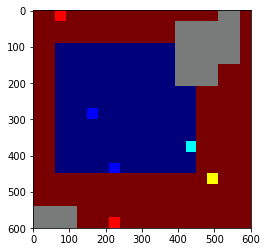

In [ ]:
env = gym.make("cap-v0") # initialize the environment
plt.imshow(env.render(mode='rgb_array'))
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)
action_space = 5
n_agent = len(env.get_team_blue)
print('red number : ', len(env.get_team_red))
print('blue number : ', len(env.get_team_blue))

## Policy Network

print(sess.run(myAgent.responsible_outputs,feed_dict=feed_dict)[:5])
print(sess.run(tf.log(myAgent.responsible_outputs),feed_dict=feed_dict)[:5])
print(sess.run(tf.exp(myAgent.responsible_outputs-1),feed_dict=feed_dict)[:5])
print(sess.run(tf.clip_by_value(tf.exp(myAgent.responsible_outputs-1),0.8,1.2),feed_dict=feed_dict)[:5])

In [ ]:
class agent():
    def __init__(self, in_size, action_size, grad_clip_norm):
        # Parameters
        self.grad_clip_norm = grad_clip_norm
        
        # Learning Rate Variables
        self.learning_rate_actor = tf.placeholder(tf.float32, shape=None, name='learning_rate_actor')
        self.learning_rate_critic = tf.placeholder(tf.float32, shape=None, name='learning_rate_critic')
        
        # Placeholders
        with tf.name_scope('holders'):
            self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
            self.action_OH = tf.one_hot(self.action_holder, action_size)
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.target_value_holder = tf.placeholder(shape=[None], dtype=tf.float32, name='target')
            self.advantage_holder = tf.placeholder(shape=[None], dtype=tf.float32, name='adv')  
            self.sampling_weight_holder = tf.placeholder(shape=[None], dtype=tf.float32, name='IS')  

        
        # Feed-Forward Network
        layer = slim.conv2d(self.state_input, 16, [5,5],# activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv_1')
        layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 16, [3,3],# activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv_2')
        self.layer = slim.flatten(layer)
        #adv_stream, val_stream = tf.split(layer, num_or_size_splits=2)
        
        # Actor stream
        actor = layers.fully_connected(self.layer, 128,
                                    activation_fn=tf.nn.relu,
                                    scope='actor_1')
        self.actor = layers.fully_connected(actor, action_size,
                                    activation_fn=None,
                                    scope='actor_2')
        self.actor_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='conv')+tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor')
        print('Actor Network')
        for var in self.actor_vars:
            print(var)
        self.output = tf.nn.softmax(self.actor, name='action')

        # Value stream
        self.critic = layers.fully_connected(self.layer, 1,
                                    activation_fn=None,
                                    scope='critic_1')
        self.critic = tf.reshape(self.critic, [-1])
        self.critic_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='conv') + tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic')
        print('Critic Network')
        for var in self.critic_vars:
            print(var)
        
        # Feed Backward
        # - compute the  loss, and use it to find gradient, and update the network
        # - May be need to add bootstrap value at the end of the value
        with tf.variable_scope('critic_train'):
            self.loss_critic = tf.reduce_mean(tf.square(self.target_value_holder - self.critic))

        with tf.variable_scope('actor_train'):
            self.entropy = -tf.reduce_mean(self.output * tf.log(self.output), name='entropy')
            self.responsible_outputs = tf.reduce_sum(self.output * self.action_OH, [1])
            #self.action_function = tf.log(self.responsible_outputs)
            self.action_function = self.sampling_weight_holder*tf.log(self.responsible_outputs) #tf.clip_by_value(self.sampling_weight_holder,0.7,1.3)
            self.loss_actor = -tf.reduce_sum(self.action_function*self.advantage_holder)
            #self.loss_actor = -tf.reduce_sum(self.action_function*self.advantage_holder)
            
        '''with tf.name_scope('update'):
            self.accumulate_gradient = tf.group([tf.assign_add(a[0],b[0]) for a,b in zip(self.grad_holders_actor, self.grads_actor)],
                                                [tf.assign_add(a[0],b[0]) for a,b in zip(self.grad_holders_critic, self.grads_critic)])
            self.clear_batch = tf.group([tf.assign(a[0],a[0]*0.0) for a in self.grad_holders_actor],
                                        [tf.assign(a[0],a[0]*0.0) for a in self.grad_holders_critic])
            self.update_batch = tf.group(self.update_actor, self.update_critic)'''
        
        with tf.name_scope('update'):
            # update using total loss
            self.loss = 0.5*self.loss_critic + self.loss_actor - self.entropy * 0.01
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate_actor)
            self.grads = self.optimizer.compute_gradients(self.loss)
            if self.grad_clip_norm:
                self.grads = [(tf.clip_by_norm(grad, self.grad_clip_norm), var) for grad, var in self.grads]
            self.grad_holders = [(tf.Variable(var, trainable=False, dtype=tf.float32, name=var.op.name+'_buffer'), var) for var in tf.trainable_variables()]
            self.update_batch = self.optimizer.apply_gradients(self.grad_holders)
            
            self.accumulate_gradient = tf.group([tf.assign_add(a[0],b[0]) for a,b in zip(self.grad_holders, self.grads)]) # add gradient to buffer
            self.clear_batch = tf.group([tf.assign(a[0],a[0]*0.0) for a in self.grad_holders])
            
        # Summary
        # Histogram output
        with tf.variable_scope('debug_parameters'):
            tf.summary.histogram('output', self.output)
            tf.summary.histogram('actor', self.actor)
            tf.summary.histogram('critic', self.critic)        
            tf.summary.histogram('action', self.action_holder)
            tf.summary.histogram('IS_weight', self.sampling_weight_holder)
            tf.summary.histogram('action_function', self.action_function)
        
        # Graph summary Loss
        with tf.variable_scope('summary'):
            tf.summary.scalar(name='actor_loss', tensor=self.loss_actor)
            tf.summary.scalar(name='critic_loss', tensor=self.loss_critic)
            tf.summary.scalar(name='total_loss', tensor=self.loss)
            tf.summary.scalar(name='Entropy', tensor=self.entropy)
        
        with tf.variable_scope('weights_bias'):
            # Histogram weights and bias
            for var in slim.get_model_variables():
                tf.summary.histogram(var.op.name, var)
                
        with tf.variable_scope('gradients'):
            # Histogram Gradients
            for var, grad in zip(tf.trainable_variables(), self.grads):
                tf.summary.histogram(var.op.name+'/grad_critic', grad[0])
        
        with tf.variable_scope('Learning_Rate'):
            # Learning Rate
            tf.summary.scalar(name='actor_lr', tensor=self.learning_rate_actor)
            tf.summary.scalar(name='critic_lr', tensor=self.learning_rate_critic)

In [ ]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(in_size=[None,VISION_dX,VISION_dY,6],action_size=5, grad_clip_norm=0) #Load the agent.
with tf.variable_scope('global_step'):
    global_step = tf.Variable(0, trainable=False, name='global_step') # global step
    increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

Actor Network
<tf.Variable 'conv_1/weights:0' shape=(5, 5, 6, 16) dtype=float32_ref>
<tf.Variable 'conv_1/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv_2/weights:0' shape=(3, 3, 16, 16) dtype=float32_ref>
<tf.Variable 'conv_2/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'actor_1/weights:0' shape=(1600, 128) dtype=float32_ref>
<tf.Variable 'actor_1/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'actor_2/weights:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'actor_2/biases:0' shape=(5,) dtype=float32_ref>
Critic Network
<tf.Variable 'conv_1/weights:0' shape=(5, 5, 6, 16) dtype=float32_ref>
<tf.Variable 'conv_1/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv_2/weights:0' shape=(3, 3, 16, 16) dtype=float32_ref>
<tf.Variable 'conv_2/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'critic_1/weights:0' shape=(1600, 1) dtype=float32_ref>
<tf.Variable 'critic_1/biases:0' shape=(1,) dtype=float32_ref>


## Session

In [ ]:
# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY, allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session()

ma_reward = MA(moving_average_step)
ma_length = MA(moving_average_step)
ma_captured = MA(moving_average_step)

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [ ]:
def record(summary_):
    with tf.device('/cpu:0'): 
        summary = tf.Summary()
        summary.value.add(tag='Records/mean_reward', simple_value=ma_reward())
        summary.value.add(tag='Records/mean_length', simple_value=ma_length())
        summary.value.add(tag='Records/mean_succeed', simple_value=ma_captured())
        writer.add_summary(summary, sess.run(global_step))
        
        #summary_str = sess.run(merged,feed_dict={myAgent.state_input:obs})
        writer.add_summary(summary_, sess.run(global_step))
        
        writer.flush()

In [ ]:
def policy_rollout(EXPLORE=False, DETERMINISTIC=True):
    # Run single episode, return the results
    s = env.reset(map_size=MAP_SIZE, policy_red=policy_red)
    #obs = one_hot_encoder(s, env.get_team_blue) # partial observation
    obs_next = one_hot_encoder(env._env, env.get_team_blue)
    
    ep_history = []
    indv_history = [[] for _ in range(len(env.get_team_blue))]
    was_alive = [ag.isAlive for ag in env.get_team_blue]
    
    prev_reward=0
    total_reward = 0
    frame=0
    
    cumulative_sampling_weight = np.zeros(n_agent)
    for frame in range(max_ep+1):
        obs = obs_next
        
        with tf.device('/cpu:0'):
            act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
        act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)] # divide by sum : normalize
        act_chosen = act_prob[np.arange(n_agent),act]
        cumulative_sampling_weight += np.log(act_chosen)
        
        s,r1,d,_ = env.step(act) #Get our reward for taking an action given a bandit.

        r = r1-prev_reward
        #if r >=1 and r < 100: # ignore capturing
        #    r = 0
        if frame == max_ep and d == False:
            r = -100
            r1 = -100
        total_reward += r
        
        if d:
            value = np.array([0.0 for _ in range(n_agent)])
        else:
            obs_next = one_hot_encoder(env._env, env.get_team_blue) # Full Observation
            value = sess.run(myAgent.critic, feed_dict={myAgent.state_input:obs_next})
        
        # Push history for individual that 'was' alive previous frame
        # [state, action, reward(later:discount), value, advantage(later)]
        
        sampling_weight = np.log(act_chosen)*(frame+1) - cumulative_sampling_weight
        #sampling_weight = np.exp(sampling_weight)
        for idx, agent in enumerate(env.get_team_blue):
            if was_alive[idx]:
                indv_history[idx].append([obs[idx],act[idx],r,value[idx],0,sampling_weight[idx]])
      
        # State Transition
        prev_reward = r1
        was_alive = [ag.isAlive for ag in env.get_team_blue]
        
        if d:
            break
    # Policy rollout for all agents are done.
    # Calculate Advantage for individual histories
    for idx, history in enumerate(indv_history):
        if len(history)==0:
            continue
        _history = np.array(history)
        values = np.array(_history[:,3])
        values_ext = np.asarray(values.tolist() + [0])
        advantages = _history[:,2] + gamma * values_ext[1:] - values_ext[:-1]
        advantages = discount_rewards(advantages,discount_factor)
        rewards = _history[:,2]
        _history[:,2] = discount_rewards(rewards,discount_factor)
        _history[:,4] = advantages
        ep_history.extend(_history)
            
    if len(ep_history) > 0:        
        ep_history = np.stack(ep_history)
    
    return [frame, ep_history, r1, env.blue_win, total_reward]

## Training

In [ ]:
if __name__=='__main__':
    ep = sess.run(global_step)
    pre_train = 10 # train critic network to adjust to env.
    exp_buffer = Experience_buffer(experience_shape=6)
    batch_history = []
    try:
        progbar = tf.keras.utils.Progbar(total_episodes,width=6)
        sess.run(myAgent.clear_batch)
        while ep < total_episodes+1:
            # Run episode
            frame, history, reward, did_won, total_reward = policy_rollout(EXPLORE=ep < pre_train,DETERMINISTIC=False)

            # Add history
            exp_buffer.add(history)

            if len(exp_buffer) > 0:
                batch_history = exp_buffer.pop(size=batch_size, shuffle=True)
                feed_dict={myAgent.learning_rate_actor :LEARNINGRATE_ACTOR,
                           myAgent.learning_rate_critic:LEARNINGRATE_CRITIC,
                           myAgent.reward_holder:batch_history[:,2],
                           myAgent.sampling_weight_holder:batch_history[:,5],
                           myAgent.action_holder:batch_history[:,1],
                           myAgent.state_input:np.stack(batch_history[:,0]),
                           myAgent.target_value_holder:batch_history[:,2],
                           myAgent.advantage_holder:batch_history[:,4]}
                with tf.device('/gpu:0'):
                    sess.run(myAgent.accumulate_gradient, feed_dict=feed_dict)
                
            if ep % mini_batch == 0 and ep != 0:
                with tf.device('/gpu:0'):
                    if ep < pre_train:
                        sess.run(myAgent.update_critic, feed_dict=feed_dict)
                    else:
                        sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    sess.run(myAgent.clear_batch)

            # decay lr
            if not LEARNING_RATE_FIX:
                if ep > pre_train: LEARNINGRATE_ACTOR  = max(LEARNINGRATE_ACTOR*LR_ACTOR_DECAY,LR_ACTOR_FINAL)
                LEARNINGRATE_CRITIC = max(LEARNINGRATE_CRITIC*LR_CRITIC_DECAY,LR_CRITIC_FINAL)
            
            # summarize and record
            ma_reward.append(reward)
            ma_length.append(frame)
            ma_captured.append(env.blue_win)   
            
            if ep % save_stat_frequency == 0 and ep != 0 and len(batch_history) > 0:
                summary_ = sess.run(merged, feed_dict=feed_dict)
                record(summary_)

            # save weight
            if ep % save_network_frequency == 0 and ep != 0:
                saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)

            # Proceed to next episode
            ep += 1
            progbar.update(ep) # update progress bar
            sess.run(increment_global_step_op)

    except KeyboardInterrupt:
        print('\n\nManually stopped the training (KeyboardInterrupt)');
        saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
        print("save: ", sess.run(global_step), 'episodes')

 13404/500000 [......] - ETA: 48:54:36

#After each step
def show_state(env, step=0):
    plt.figure()
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d" % (step))

    plt.pause(0.05)  # pause for plots to update
try:
    start_time = time.time()
    #env.seed(1)
    s = env.reset(map_size=10, policy_red=policy_red)
    
    total_reward = 0
    prev_reward=0
    frame=0
    for frame in range(max_ep+1):
        obs = one_hot_encoder2(env._env, env.get_team_blue)
        act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
        print(act_prob)
        act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)]
        s,r1,d,_ = env.step(act)
        r = r1-prev_reward
        if frame == max_ep and d == False:
            r = -100
            r1 = -100
        total_reward += r
        # render and sleep are not needed for score analysis
        
        show_state(env, frame)
        prev_reward = r1
        if d:
            break

    print("Time: %.2f s, rscore: %.2f" %
        ((time.time() - start_time),total_reward))
    
except KeyboardInterrupt:
    print('\n\nManually stopped the running (KeyboardInterrupt)');